In [6]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn
from collections import Counter
seaborn.set_context("talk")

In [7]:
### Consolidate multiple log files into one

In [8]:
def custom_parse_log(fname):
    with open(fname) as f:
        lines = f.readlines()

    messages = []
    for line in lines:
      for mod in [" __getitem__:","train_step:"]:
          if mod in line:
                try:
                    parsed_line = line.split(mod)[-1].strip()
                    messages.append(json.loads(parsed_line))
                except json.JSONDecodeError:
                    pass


    c = Counter([m['event'] for m in messages])
    print(c)
    return messages

In [12]:
logs =["../logs/2024_03_29_03:36_finetune.log", "../logs/2024_03_29_04:18_finetune.log", 
"../logs/2024_03_29_03:38_finetune.log",	"../logs/2024_03_29_04:19_finetune.log",
"../logs/2024_03_29_03:54_finetune.log",	"../logs/2024_03_29_04:20_finetune.log",
"../logs/2024_03_29_03:56_finetune.log",	"../logs/2024_03_29_04:40_finetune.log",
"../logs/2024_03_29_04:17_finetune.log",	"../logs/2024_03_29_04:42_finetune.log"]

msgs = []
for log in logs:
    msgs.extend(custom_parse_log(log))

with open("../logs/2024_03_29_03:35_finetune_msgs.log", "w") as f:
    for msg in msgs:
        f.write(json.dumps(msg)+"\n")

Counter({'training start': 998, 'training end': 998, 'get-batch start': 2, 'get-batch end': 2})
Counter({'get-batch start': 2816, 'get-batch end': 2816})
Counter({'get-batch start': 37376, 'get-batch end': 37376})
Counter({'get-batch start': 12544, 'get-batch end': 12544})
Counter({'get-batch start': 3456, 'get-batch end': 3456})
Counter({'get-batch start': 24832, 'get-batch end': 24832})
Counter({'get-batch start': 37376, 'get-batch end': 37376})
Counter({'get-batch start': 3456, 'get-batch end': 3456})
Counter({'get-batch start': 640, 'get-batch end': 640})
Counter({'get-batch start': 17977, 'get-batch end': 17975})


In [10]:
### Functions from https://github.com/earth-mover/dataloader-demo/blob/main/plot.ipynb

In [11]:
def parse_log(fname):
    with open(fname) as f:
        lines = f.readlines()

    messages = []
    for line in lines:
        try:
            messages.append(json.loads(line.strip()))
        except json.JSONDecodeError:
            pass


    c = Counter([m['event'] for m in messages])
    print(c)
    return messages

In [24]:
def plot_wait_time(messages, ax, title="Time waiting"):
    if title:
        ax.set_title(title)

    wait_times = []
    end = None
    for m in messages:
        if m["event"] == "training end":
            end = m["time"]
        if m["event"] == "training start" and end is not None:
            wait_times.append(m["time"] - end)

    wait_times = np.array(wait_times)
    max_show = wait_times.mean() + 3 * wait_times.std()

    print("average wait time", wait_times.mean())

    ax.hist(wait_times, bins=np.linspace(0, max_show, 100), color="#6D0EDB")[-1]
    ax.set_xlabel("time (sec)")

def stats(messages):
    origin = messages[0]["time"]
    data = {"batches": [], "training" : []}

    for m in messages:
        t = m["time"] - origin


        if m["event"] == "get-batch end":
  
            data["batches"].append(m["duration"])

        if m["event"] == "training end":

            data["training"].append(m["duration"])

    wait_times = []
    end = None
    for m in messages:
        if m["event"] == "training end":
            end = m["time"]
        if m["event"] == "training start" and end is not None:
            wait_times.append(m["time"] - end)


    data['wait_times']=wait_times

    return data



def plot_log(messages, ax, title=""):
    origin = messages[0]["time"]
    #assert messages[0]["event"] == "run start"

    rows = {"setup": 3, "get-batch": 2, "train": 1, "epoch": 0}

    ax.set_yticks(list(rows.values()), labels=list(rows))

    if title:
        ax.set_title(title)

    data = {"batches": [], "training" : []}

    for m in messages:
        t = m["time"] - origin

        if m["event"] == "setup end":
            ax.barh(
                rows["setup"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#6D0EDB",
                zorder=1,
            )

        if m["event"] == "get-batch end":
            ax.barh(
                rows["get-batch"],
                m["duration"],
                left=t - m["duration"],
                # alpha=0.5,
                color="#C396F9",
                zorder=1,
            )
            data["batches"].append(m["duration"])

        if m["event"] == "training end":
            ax.barh(
                rows["train"],
                m["duration"],
                left=t - m["duration"],
                color="#FF6554",
                zorder=1,  # edgecolor="k", linewidth=0.1,
            )
            data["training"].append(m["duration"])

        if m["event"] == "epoch end":
            ax.barh(
                rows["epoch"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#FF9E0D",
                zorder=1,
            )

    ax.grid(axis="x", zorder=0, alpha=0.5)
    ax.set_xlabel("time (sec)")

    print("average batch duration", np.mean(data["batches"]))
    print("average training duration", np.mean(data["training"]))


def plot(fname):
    messages = parse_log(fname)
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6), width_ratios=[3, 1], dpi=400)

    plot_log(messages, axes[0], title="")
    plot_wait_time(messages, axes[1], title="")

    for m in messages:
        if m["event"] == "run start":
            text_str = "\n".join([f"{k}: {v}" for k, v in m["locals"].items() if v is not None])
            props = dict(boxstyle="round", facecolor="#F5F5F5", alpha=0.5)
            fig.text(
                0.5,
                -0.03,
                text_str,
                fontsize=14,
                horizontalalignment="center",
                verticalalignment="top",
                bbox=props,
            )
            break

## Results

Counter({'get-batch start': 40834, 'get-batch end': 40834, 'training start': 292, 'training end': 292})
average batch duration 0.05017098754815177
average training duration 0.9611107764178759
average wait time 6.254321468654776


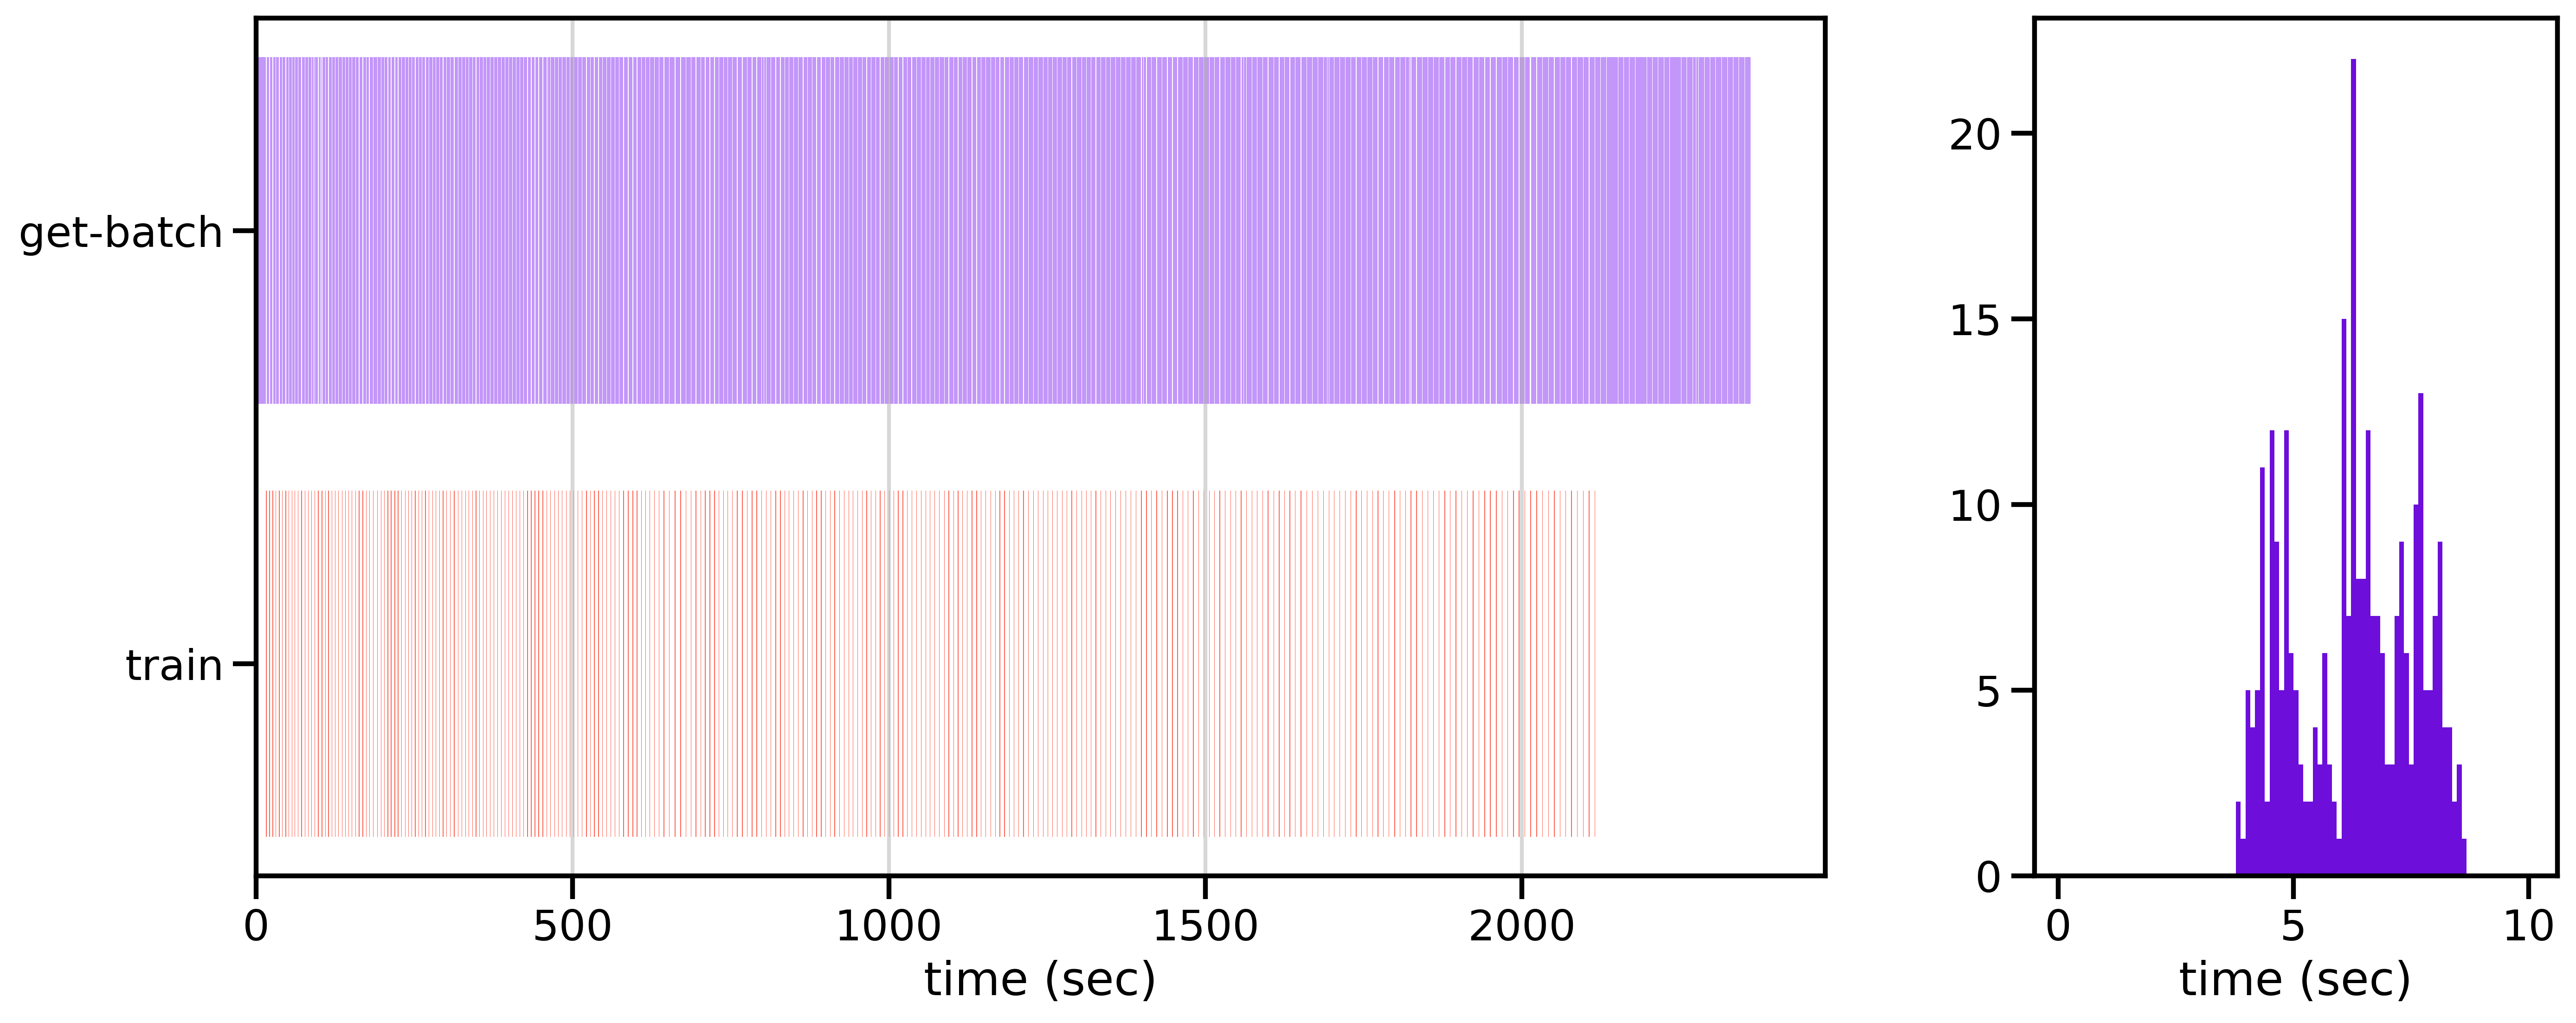

In [90]:
fname = "../logs/2024_03_28_05:30_finetune_msgs.log" # Baseline
plot(fname)

Counter({'get-batch start': 40834, 'get-batch end': 40834, 'training start': 292, 'training end': 292})
average batch duration 0.06881577074571531
average training duration 1.3591004748866982
average wait time 0.01074214571530057


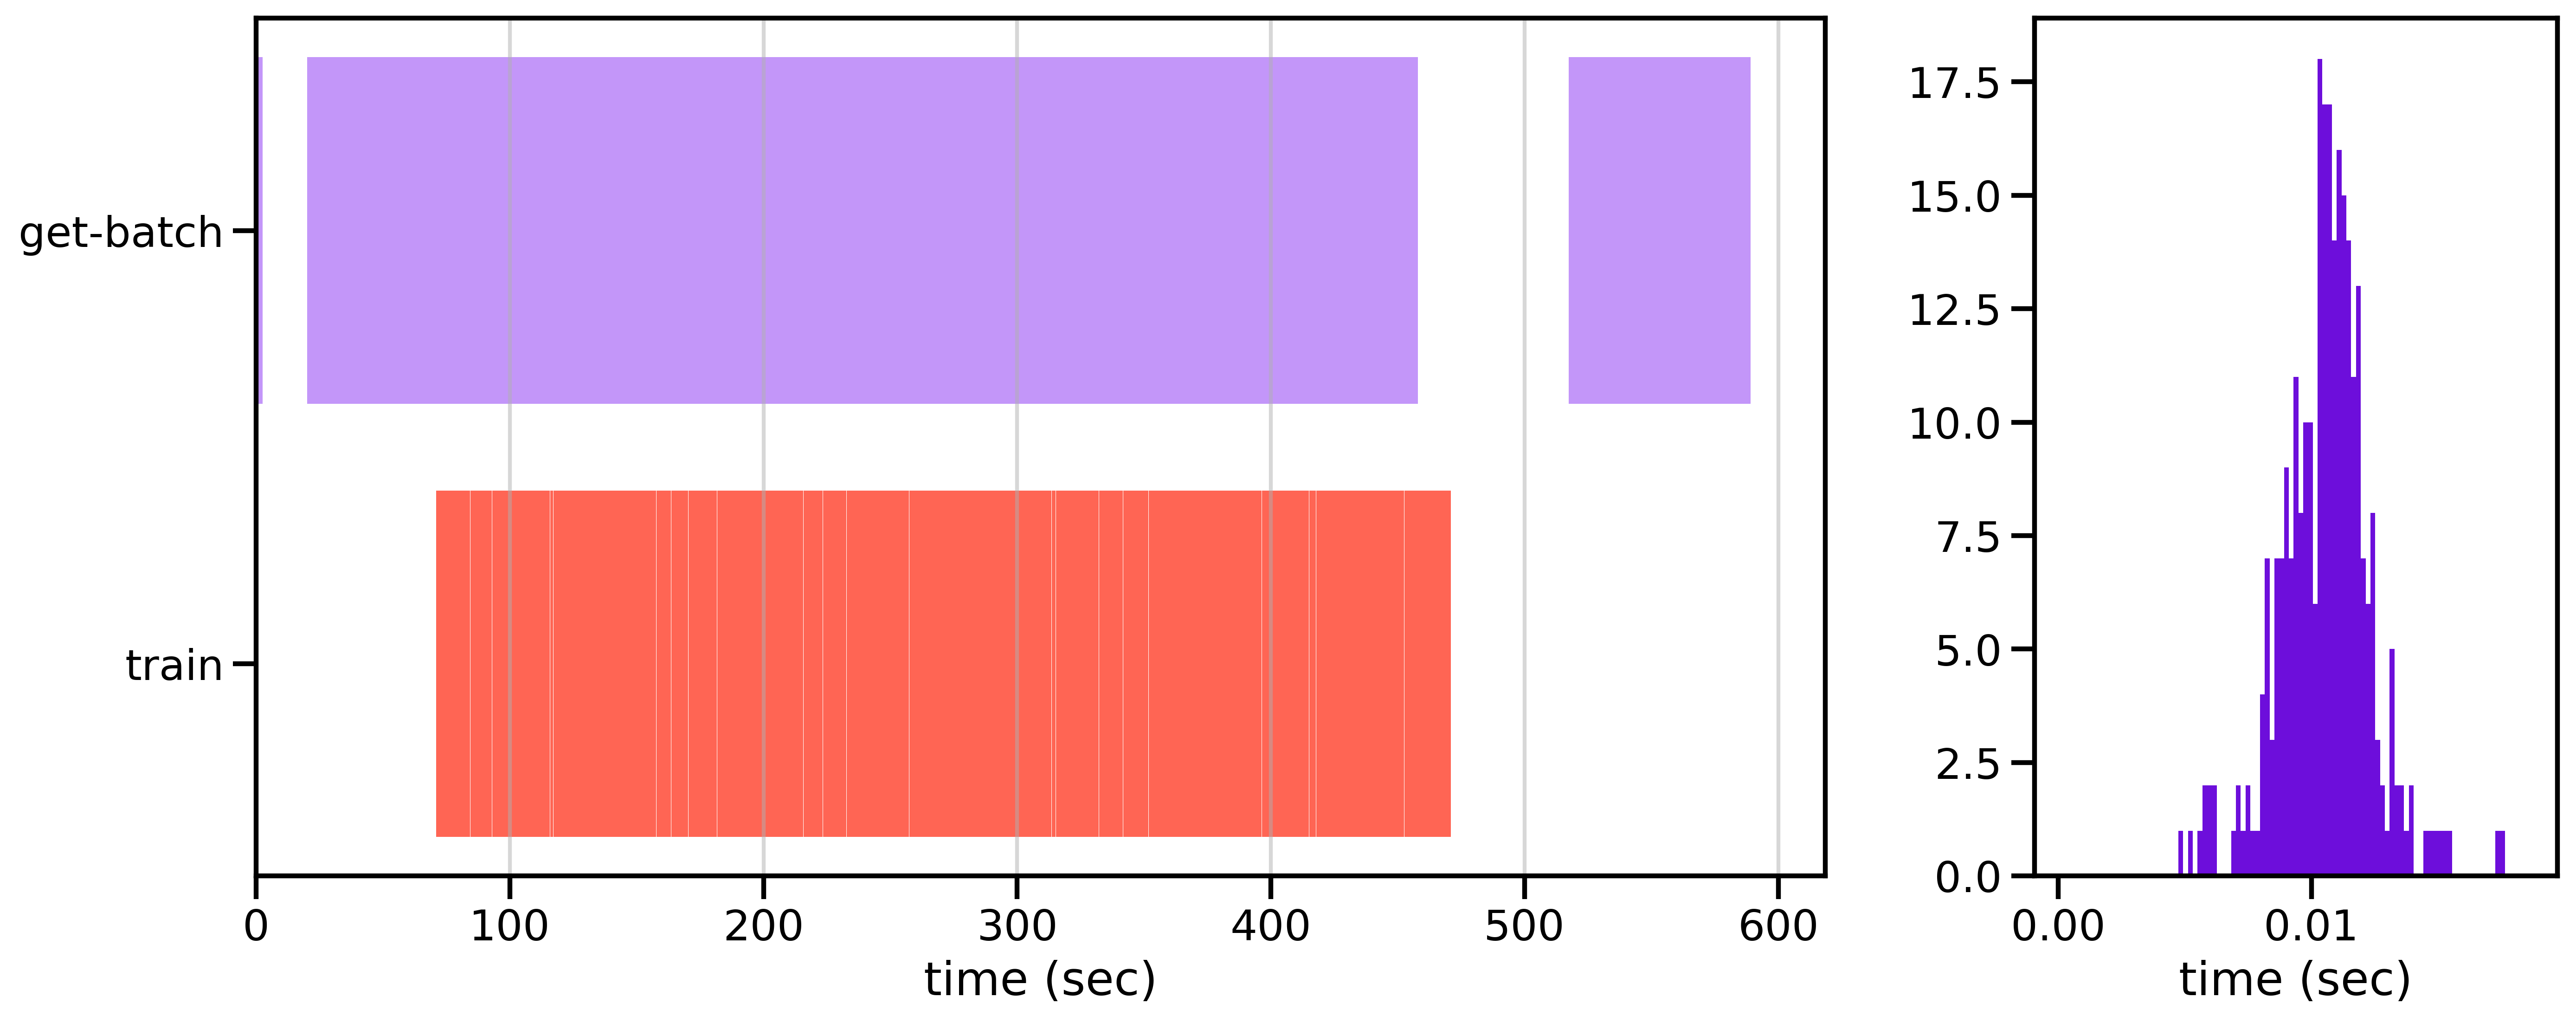

In [89]:
fname = "../logs/2024_03_28_08:20_finetune_msgs.log". # Dask 2 workers, prefetch 3, Dataloader workers 6
plot(fname)

Counter({'get-batch start': 40834, 'get-batch end': 40834, 'training start': 292, 'training end': 292})
average batch duration 0.08631699622515256
average training duration 1.3687546073573909
average wait time 0.0101390564974231


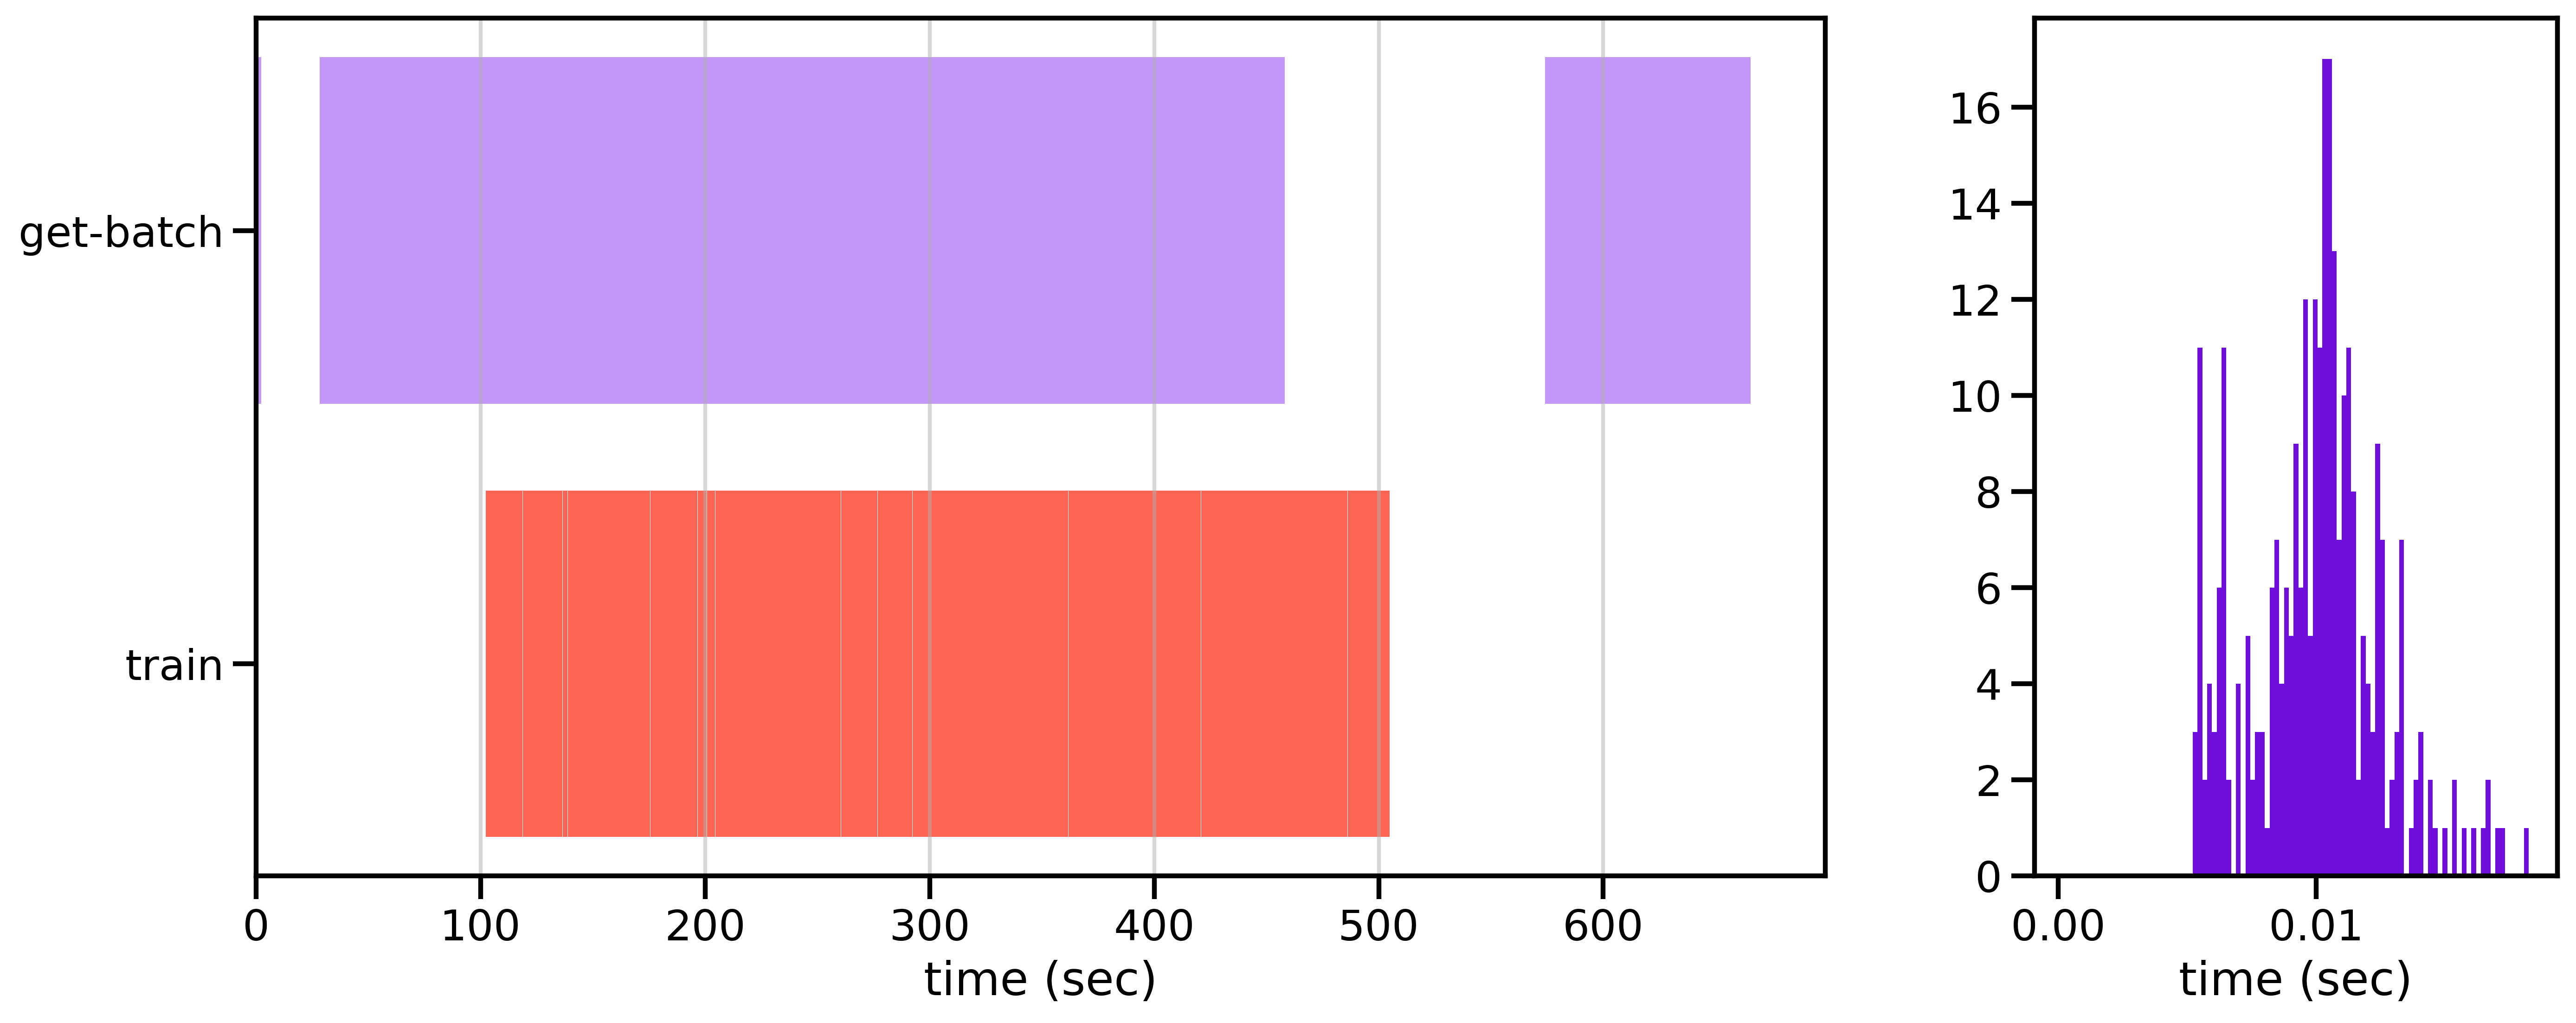

In [94]:
fname = "../logs/2024_03_28_08:55_finetune_msgs.log" # Dask 3 workers, prefetch 6, Dataloader workers 9
plot(fname)

Counter({'get-batch start': 40834, 'get-batch end': 40834, 'training start': 292, 'training end': 292})
average batch duration 0.0550966269765468
average training duration 1.1937995389716265
average wait time 0.3822667000629648


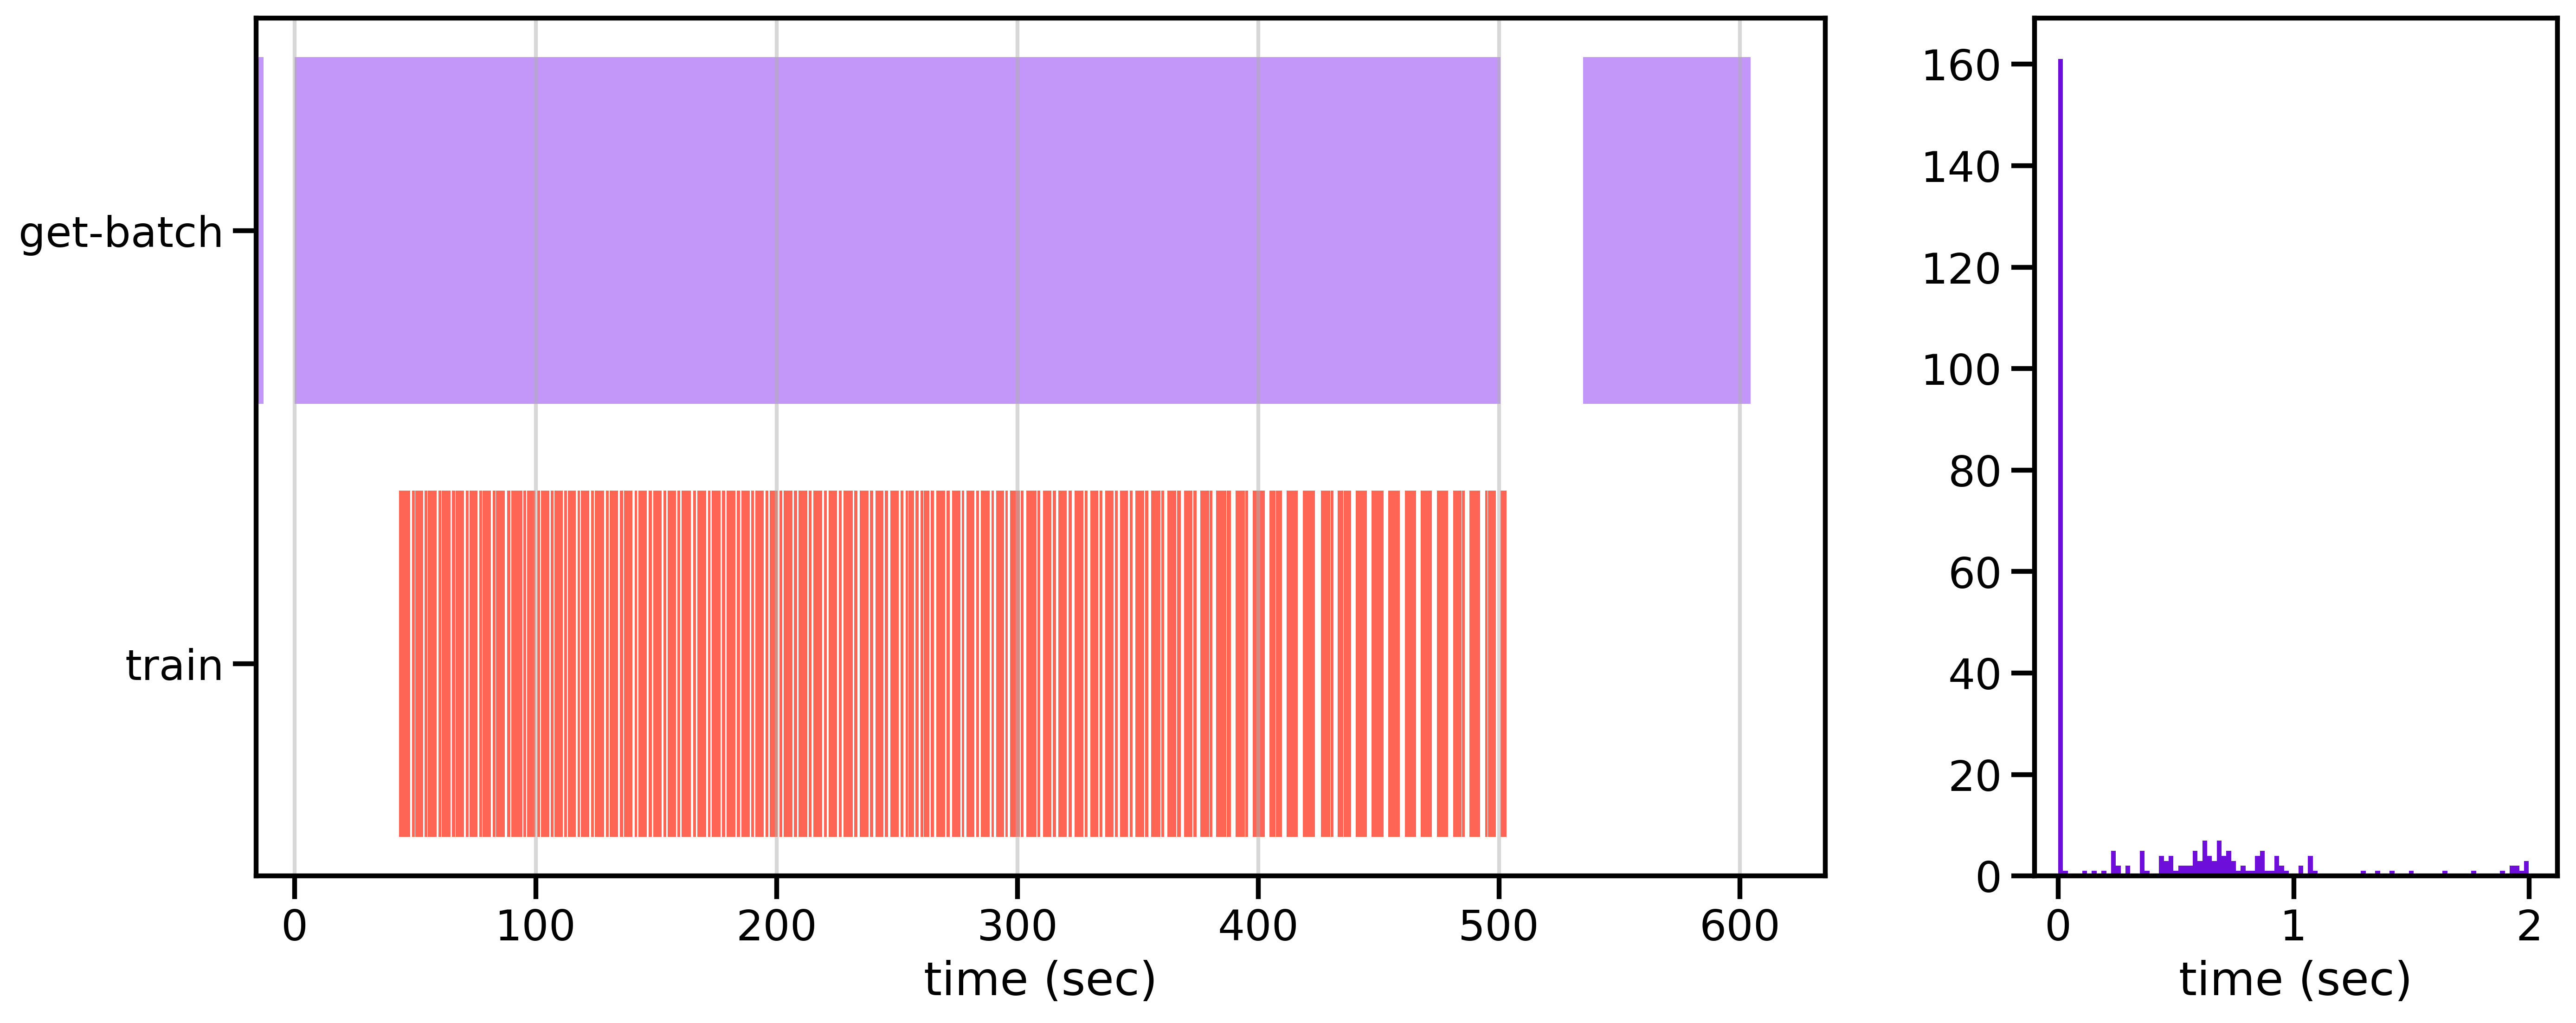

In [96]:
fname = "../logs/2024_03_28_09:15_finetune_msgs.log" # Dask 1 workers, prefetch 3, Dataloader workers 4
plot(fname)

Counter({'get-batch start': 40834, 'get-batch end': 40834, 'training start': 292, 'training end': 292})
average batch duration 0.0676435567188632
average training duration 1.3253099632589784
average wait time 0.0102617445680284


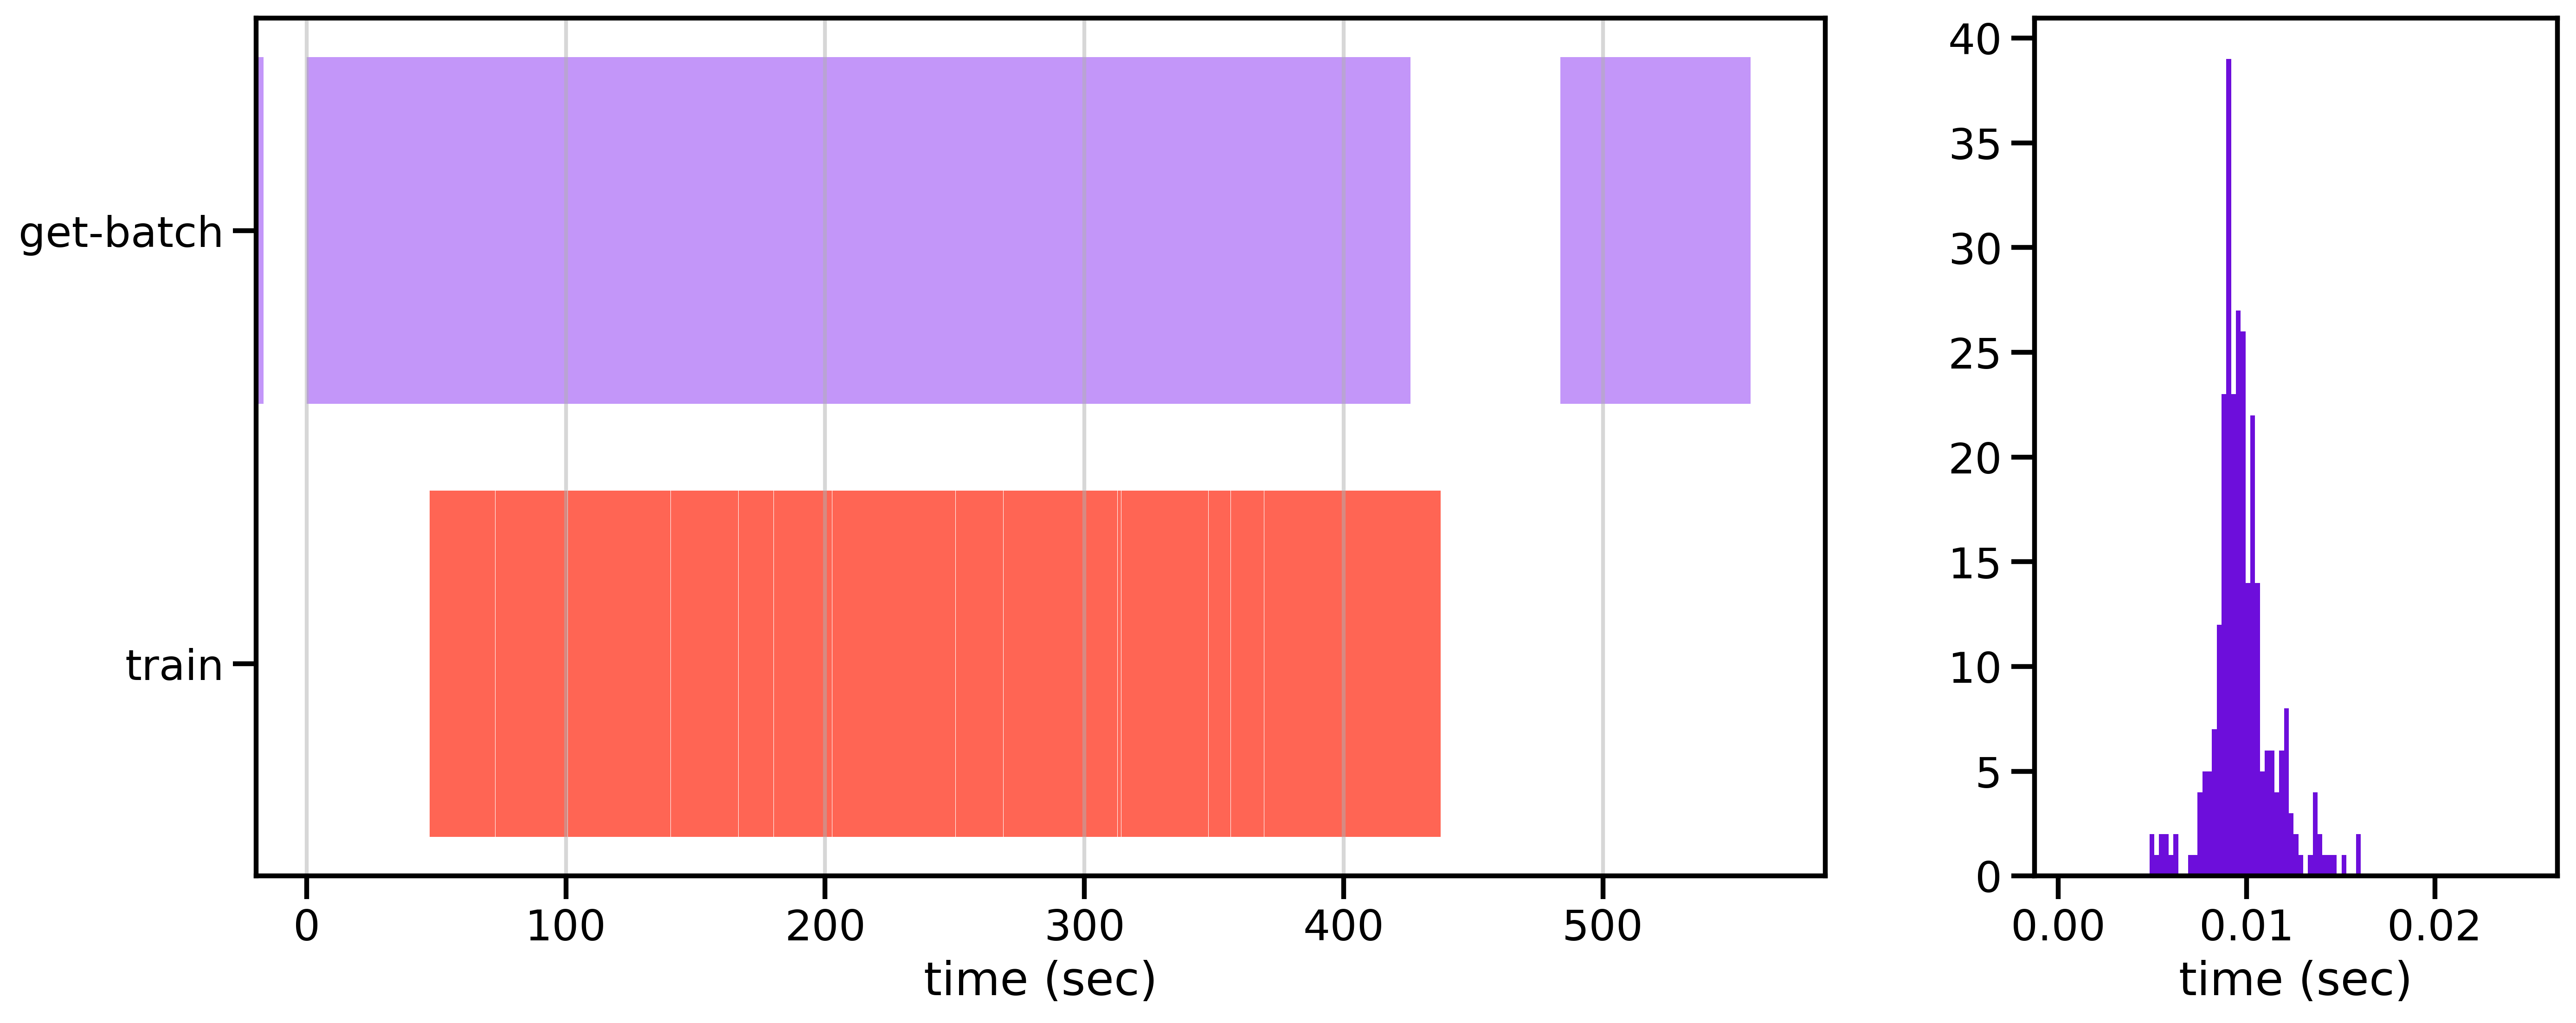

In [98]:
fname = "../logs/2024_03_28_09:35_finetune_msgs.log" # Dask default config, prefetch 3, Dataloader workers 6
plot(fname)

Counter({'get-batch start': 140475, 'get-batch end': 140473, 'training start': 998, 'training end': 998})
average batch duration 0.06574784728621982
average training duration 1.629529941535904
average wait time 2.621997373632586


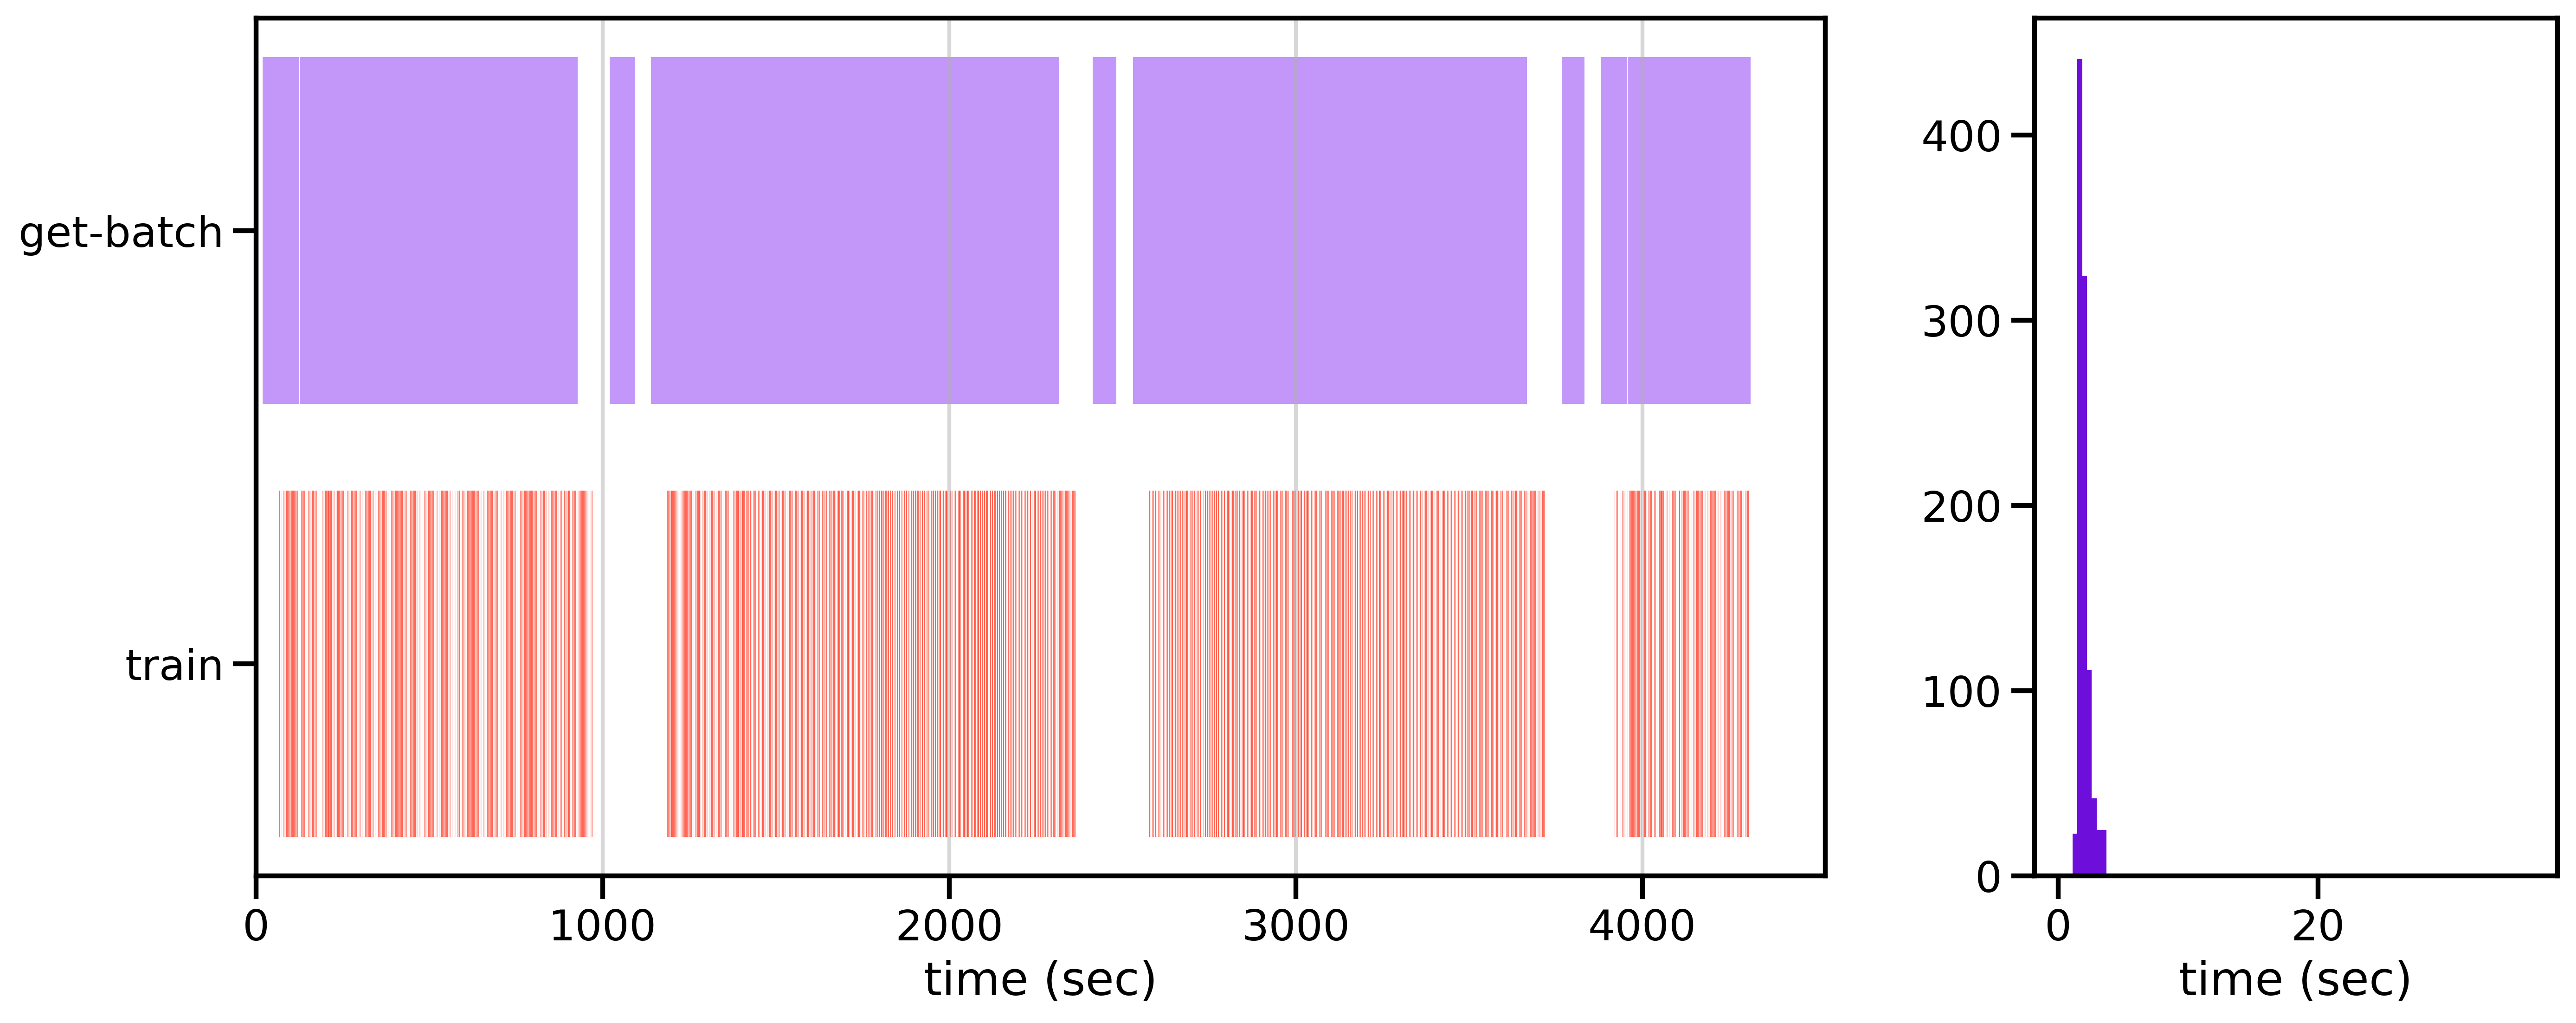

In [15]:
fname = "../logs/2024_03_29_03:35_finetune_msgs.log"
plot(fname)

In [25]:
messages = parse_log(fname)
data = stats(messages)

Counter({'get-batch start': 140475, 'get-batch end': 140473, 'training start': 998, 'training end': 998})


In [28]:
max(data['wait_times'])

212.9745638370514